In [8]:
from imutils import paths
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pytorch_lightning as pl
# Torch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [9]:
DATASET_PATH = './data'
CHECKPOINT_PATH = './saved_models/'
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# set device to GPU if CUDA is available
if use_cuda:
    device = torch.device('cuda:0') 
else:
    device = torch.device('cpu')

print('Device:', device)
print('Number of workers:', NUM_WORKERS)

Device: cuda:0
Number of workers: 24


In [10]:
# Download Caltech101 dataset
dataset_caltech101 = datasets.Caltech101(root=DATASET_PATH + '/', download=True)

0it [00:00, ?it/s]

Extracting ./data/caltech101\101_ObjectCategories.tar.gz to ./data/caltech101


0it [00:00, ?it/s]

Extracting ./data/caltech101\Annotations.tar to ./data/caltech101


In [11]:
image_paths = list(paths.list_images(DATASET_PATH))

data =  []
classes = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    data.append(image)
    classes.append(label)

data = np.array(data, dtype=object)
classes = np.array(classes, dtype=object)

In [12]:
# One hot encode
lb = LabelBinarizer()
classes = lb.fit_transform(classes)
print(f'Total number of classes: {len(lb.classes_)}')

Total number of classes: 101


In [13]:
# Divide the data into train (60%), validation (20%), and test (20%) set
(X, x_test , Y, y_test) = train_test_split(data, classes, test_size=0.2, stratify=classes, random_state=42)
(x_train, x_valid, y_train, y_valid) = train_test_split(X, Y, test_size=0.25, random_state=42)
print(f'x_train examples: {x_train.shape}\nx_valid examples: {x_valid.shape}\nx_test examples: {x_test.shape}')

x_train examples: (5205,)
x_valid examples: (1736,)
x_test examples: (1736,)


In [14]:
# Custom image dataset
class ImageDataset(Dataset):
    def __init__(self, images, classes=None, transforms=None):
        self.X = images
        self.classes = classes
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.classes is not None:
            return (data, self.classes[i])
        else:
            return data

In [15]:
# Custom transformation
class Transformation(object):

    def __init__(self, transforms):
        self.transforms = transforms
        self.n_views = 2

    def __call__(self, x):
        return [self.transforms(x) for i in range(self.n_views)]

In [16]:
# Define transforms
train_transforms = transforms.Compose([transforms.ToPILImage(), # Convert to PIL Image first
                                       transforms.RandomHorizontalFlip(), # Random horizontal flip
                                       transforms.Resize((224, 224)), # Resize the image in 224 X 244 before cropping
                                       transforms.RandomResizedCrop(224), # Random crop with size of 96 X 96
                                       transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8), # Random color jitter
                                       transforms.RandomGrayscale(p=0.2), # Random gray scale
                                       transforms.GaussianBlur(kernel_size=9), # Apply Gaussian blur
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], # Data normalization 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.ToPILImage(), # Convert to PIL Image first
                                       transforms.Resize((224, 224)), # Resize the image in 200 X 200 before cropping
                                       transforms.RandomResizedCrop(224), # Random crop with size of 96 X 96
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], # Data normalization
                                                           [0.229, 0.224, 0.225])])

In [17]:
train_data = ImageDataset(x_train, y_train, Transformation(train_transforms))
valid_data = ImageDataset(x_valid, y_valid, Transformation(valid_transforms))
test_data = ImageDataset(x_test, y_test, Transformation(valid_transforms))

In [18]:
import json
l_dict = { k + 1:v for k, v in enumerate(lb.classes_) }

with open('class_to_label.json', 'w') as outfile:
    json.dump(l_dict, outfile)

with open('class_to_label.json', 'r') as f:
    class_to_label = json.load(f)

class_to_label


{'1': 'Faces',
 '2': 'Faces_easy',
 '3': 'Leopards',
 '4': 'Motorbikes',
 '5': 'accordion',
 '6': 'airplanes',
 '7': 'anchor',
 '8': 'ant',
 '9': 'barrel',
 '10': 'bass',
 '11': 'beaver',
 '12': 'binocular',
 '13': 'bonsai',
 '14': 'brain',
 '15': 'brontosaurus',
 '16': 'buddha',
 '17': 'butterfly',
 '18': 'camera',
 '19': 'cannon',
 '20': 'car_side',
 '21': 'ceiling_fan',
 '22': 'cellphone',
 '23': 'chair',
 '24': 'chandelier',
 '25': 'cougar_body',
 '26': 'cougar_face',
 '27': 'crab',
 '28': 'crayfish',
 '29': 'crocodile',
 '30': 'crocodile_head',
 '31': 'cup',
 '32': 'dalmatian',
 '33': 'dollar_bill',
 '34': 'dolphin',
 '35': 'dragonfly',
 '36': 'electric_guitar',
 '37': 'elephant',
 '38': 'emu',
 '39': 'euphonium',
 '40': 'ewer',
 '41': 'ferry',
 '42': 'flamingo',
 '43': 'flamingo_head',
 '44': 'garfield',
 '45': 'gerenuk',
 '46': 'gramophone',
 '47': 'grand_piano',
 '48': 'hawksbill',
 '49': 'headphone',
 '50': 'hedgehog',
 '51': 'helicopter',
 '52': 'ibis',
 '53': 'inline_skate',

Global seed set to 42


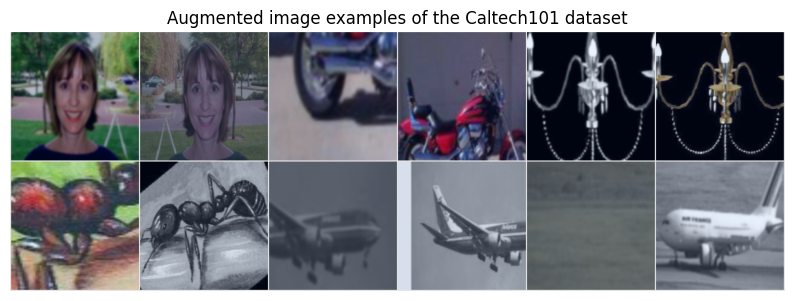

In [19]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6

images = torch.stack([image for idx in range(NUM_IMAGES) for image in train_data[idx][0]], dim=0)

img_grid = torchvision.utils.make_grid(images, nrow=6, normalize=True, pad_value=0.9)

img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the Caltech101 dataset')
plt.imshow(img_grid,)
plt.axis('off')
plt.show()
plt.close()

In [22]:
testing = torchvision.models.resnet50()
print(testing)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [24]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super(Encoder, self).__init__()

        self.model = models.resnet18()
        
        # Replace the fc layer with an Identity function
        self.model.fc = Identity()

    def forward(self, x):     
        x = self.model(x)   
        return x

In [28]:
class Projection(nn.Module):
    def __init__(self, hidden_dim=2048, input_dim=2048, output_dim=128):
        super(Projection, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim        
        self.output_dim = output_dim
        
        # Add mlp projection head
        self.model = nn.Sequential(
            nn.Linear(in_features=self.input_dim, out_features=self.hidden_dim, bias=True),
            nn.BatchNorm1d(self.input_dim),
            nn.ReLU(),
            nn.Linear(in_features=self.input_dim, out_features=self.output_dim, bias=False),
            nn.BatchNorm1d(self.input_dim),
        )

    def forward(self, x):
        x = self.model(x)
        return F.normalize(x, dim=1)


def define_param_groups(model, weight_decay, optimizer_name):
    def exclude_from_wd_and_adaptation(name):
        if 'bn' in name:
            return True
        if optimizer_name == 'lars' and 'bias' in name:
            return True

    param_groups = [
        {
            'params': [p for name, p in model.named_parameters() if not exclude_from_wd_and_adaptation(name)],
            'weight_decay': weight_decay,
            'layer_adaptation': True,
        },
        {
            'params': [p for name, p in model.named_parameters() if exclude_from_wd_and_adaptation(name)],
            'weight_decay': 0.,
            'layer_adaptation': False,
        },
    ]
    return param_groups

In [29]:
class ContrastiveLoss(nn.Module):
    """
    Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, out_1, out_2, temperature):
        out = torch.cat([out_1, out_2], dim=0)
        n_samples = len(out)

        # Full similarity matrix
        cov = torch.mm(out, out.t().contiguous())
        sim = torch.exp(cov / temperature)

        mask = ~torch.eye(n_samples, device=sim.device).bool()
        neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)

        # Positive similarity
        pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
        pos = torch.cat([pos, pos], dim=0)

        loss = -torch.log(pos / neg).mean()
        return loss

In [14]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, input_dim, output_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        
        # Base/backbone model f(x) -> h
        self.encoder = Encoder()  # Output of last linear layer
                
        # The MLP/projection g(h) -> z
        self.projection = Projection(self.hparams.hidden_dim, self.hparams.input_dim, self.hparams.output_dim)

        # Loss ContrastiveLoss/nt_xent_loss
        self.contrastive_loss = ContrastiveLoss()

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.encoder(imgs)
        
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='valid')

In [15]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'simclr'),
                         accelerator='gpu' if str(device).startswith('cuda') else 'cpu',
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='valid_acc_top5'), LearningRateMonitor('epoch')])
    
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'simclr.ckpt')
    
    if os.path.isfile(pretrained_filename):        
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        # Dataloaders
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
        valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)
        
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        print('Fit the model')
        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)     
        print('Create a check point after training the model')   
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [16]:
torch.set_float32_matmul_precision('medium')
simclr_model = train_simclr(batch_size=256,
                            max_epochs=100,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
c:\Users\james\anaconda3\envs\env_pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\james\anaconda3\envs\env_pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | encoder | ResNet | 11.5 M
-----------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.019    Total estim

Fit the model


Sanity Checking: 0it [00:00, ?it/s]

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir ./saved_models/simclr/lightning_logs/